# Running the nonadiabatic molecular dynamics (NA-MD)

In this tutorial, we perform NA-MD using the NACs computed in [step3](../../8_step3_cp2k/2_xTB). After the dynamic is done, we will fit the data using a stretched-compressed exponential function. We only do the dynamics for the NACs computed for the system in the xTB framework. The reason is that doing the NA-MD for the other system we considered with DFT, the rutile-$TiO_2$ unit cell, is exactly the same as below and you just need to modify some parameters as is explained in the [README.md](README.md) file. 

## Table of contents
<a name="toc"></a>
1. [Importing needed libraries](#import)
2. [Overview of required files](#required_files)
3. [Defining the functions and variables](#def_fun_var)
4. [Run the dynamics](#run_dyn) 
5. [Decoherence times](#deco_times)
6. [Fitting data](#fit_data)

### A. Learning objectives

* To be able to run the NA-MD using Libra
* To be able to compute the decoherence times
* To be able to compute the average NA-MD timescales

### B. Use cases

* [Run the dynamics](#run_dyn)
* [Decoherence times](#deco_times)
* [Fitting data](#fit_data)


### C. Functions

- `libra_py`
  - `data_conv`
  - `data_stat`
  - `data_outs`
  - `data_read`
  - `workflows`
    - `nbra`
      - [`step4`](#run_dyn)
        - [`namd_workflow`](#run_dyn)
      - [`decoherence_times`](#deco_times)
        - [`decoherence_times`](#deco_times)
  - `units`
    - `fs2au`
    


## 1. Importing needed libraries <a name="import"></a>
[Back to TOC](#toc)

Since the data are stored in sparse format using `scipy.sparse` library, we need to load this library to read them. Import `numpy`, `scipy.sparse`, `data_conv`, `data_outs`, `data_stat`, `data_io`, `units`, and `step4` modules and also the `ann` for doing the NA-MD using artificial neural netwrok (we do not cover this in here). Also, `multiprocessing` library will be needed to simultaneously run the NA-MD in different batches.
The `scipy.optimize.curve_fit` will be used to fit the data and plot them using `matplotlib`.

In [1]:
import os
import sys
import math
import time
import glob 

import multiprocessing as mp
import numpy as np
import scipy.sparse as sp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline

from liblibra_core import *
import util.libutil as comn
from libra_py import units as units
from libra_py import data_conv, data_stat, data_outs, data_read
import libra_py.workflows.nbra.decoherence_times as decoherence_times
import libra_py.workflows.nbra.step4 as step4
import libra_py.workflows.nbra.ann as ann

/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/import

## 2. Overview of required files <a name="required_files"></a>
[Back to TOC](#toc)

The only files that we need are the NACs obtained in [this tutorial](../../8_step3_cp2k/2_xTB/res-mixed-basis).

The `inputs.tar.bz2` archive is the `data.tar.bz2` archive from that tutorial. 

We only need to unpack it:

    tar -xjf inputs.tar.bz2

## 3. Defining the functions and variables <a name="def_fun_var"></a>
[Back to TOC](#toc)

The helper functions are used in here. We will set the parameters in here. The list of all parameters are completely explained in the [README.md](README.md) file.

In [2]:
class tmp:
    pass


#obj = tmp()
#obj.basis_transform = CMATRIX(2,2)
#obj.basis_transform.identity()


def compute_model_nbra_direct_global(q, params, full_id):
    """   
    Read in the vibronic Hamiltonians along the trajectories    

    Args: 
        q ( MATRIX(1,1) ): coordinates of the particle, ndof, but they do not really affect anything
        params ( dictionary ): model parameters

            * **params["timestep"]** ( int ):  [ index of the file to read ]
            * **params["prefix"]**   ( string ):  [ the directory where the hdf5 file is located ]
            * **params["filename"]** ( string ):  [ the name of the HDF5 file ]
        
    Returns:       
        PyObject: obj, with the members:

            * obj.hvib_adi ( CMATRIX(n,n) ): adiabatic vibronic Hamiltonian 
            
    """

    timestep = params["timestep"]
    nadi = params["nstates"]

    #=========== Basis transform, if available =====
    basis_transform = CMATRIX(nadi, nadi)
    basis_transform.identity()

    #========= Time-overlap matrices ===================
    time_overlap_adi = CMATRIX(nadi, nadi)
    time_overlap_adi.identity()

    obj = tmp()
    obj.ham_adi = params["HADI"][timestep]
    obj.nac_adi = params["NAC"][timestep]
    obj.hvib_adi = params["HVIB"][timestep]
    obj.basis_transform = basis_transform
    obj.time_overlap_adi = params["ST"][timestep]

    return obj




def compute_model(q, params, full_id):
    model = params["model"]
    res = None

    if model==1:
        pass
    elif model==2:
        #res = ham.compute_model_nbra_2state_direct(q, params, full_id)        
        res = compute_model_nbra_direct_global(q, params, full_id)
    elif model==3:
        res = ann.compute_model_nbra_ann(q, params, full_id)
        #res.time_overlap_adi = ST[ params["timestep"] ]

    return res



#if __name__ == '__main__':

def run_dynamics(case, what):



    if case=="direct" and what in [0, 2] :
        os.system("mkdir ADI")
    elif case=="ann" and what in [0, 2]:
        os.system("mkdir namd_ann")


    nthreads = 8
    methods = {0:"FSSH", 1:"IDA", 2:"mSDM", 3:"DISH", 21:"mSDM2", 31:"DISH2" }
    init_states = [10]
    tsh_methods = [0,1]#, 1]
    batches = list(range(4))





    #================== SET UP THE DYNAMICS AND DISTRIBUTED COMPUTING SCHEME  ===============                      

    rnd = Random()

    rates = None
    gaps = None

    params_common = { "path_to_res_files":'/projects/academic/cyberwksp21/Students/jstetzler/libra_examples/Tutorials_Libra/6_dynamics/2_nbra_workflows/8_step3_cp2k/1_DFT/res-mb-sd-DFT', "is_sparse": True,
                      "Hvib_re_prefix": 'Hvib_ci_', "Hvib_re_suffix": '_re',
                      "Hvib_im_prefix": 'Hvib_ci_', "Hvib_im_suffix": '_im', "istep": 1200,
                      "St_re_prefix": 'St_ci_', "St_re_suffix": '_re',
                      "nsteps": 199, "dt":1*units.fs2au, "is_parallel": True,
                      "ntraj":100, "x0":[-4.0], "p0":[4.0], "masses":[2000.0], "k":[0.01],
                      "nstates":10, "istate":[1, 0],
                      "which_adi_states":range(10), "which_dia_states":range(10),
                      "rep_ham":1, "tsh_method":0, "force_method":0, "nac_update_method":0,
                      "hop_acceptance_algo":31, "momenta_rescaling_algo":0,
                      "time_overlap_method":1, "mem_output_level":-1,  "txt_output_level":-1, "txt2_output_level":3,
                      "properties_to_save": ['timestep', 'time', 'SH_pop', 'SH_pop_raw'],
                      "state_tracking_algo":0, "convergence":0,  "max_number_attempts":100,
                      "do_phase_correction":0,
                      "min_probability_reordering":0.01, "decoherence_algo":0, "Temperature": 300.0,
                      "isNBRA":1
                    }


    #=========================== DIRECT ==============================

    if case == "direct":

        dyn_params = dict(params_common)
        #dyn_params.update({ "dir_prefix":"namd_regular","rates":1,"gaps":1})
        dyn_params.update({ "dir_prefix":"ADI"})
        ham_rep, is_nbra = 1, 1


        if what in [0, 2]:
            model_params_direct = {"model":2, "filename":None}
            HADI, HVIB, NAC, ST, nstates = data_read.get_all_data(params_common) #["nsteps"],  istep=0, nstates = 5)
            params_common["nstates"] = nstates
            dyn_params["nstates"] = nstates
            model_params_direct["nstates"] = nstates
            model_params_direct["istep"] = params_common["istep"]
            model_params_direct["HVIB"] = HVIB
            model_params_direct["HADI"] = HADI
            model_params_direct["NAC"] = NAC
            model_params_direct["ST"] = ST
            print(model_params_direct, 'Done with reading the files... Going to step4.')
            tau, rates = decoherence_times.decoherence_times_ave([HVIB], [0], params_common['nsteps'], 0)
            dE         = decoherence_times.energy_gaps_ave(      [HVIB], [0], params_common['nsteps'])
            avg_deco   = tau * units.au2fs
            avg_deco = data_conv.MATRIX2nparray(avg_deco)
            for i in range(len(avg_deco)):
                avg_deco[i][i] = 0
            np.savetxt('average_decoherence.txt', avg_deco.real)

            step4.namd_workflow(dyn_params, compute_model, model_params_direct, rnd, nthreads,
                                methods, init_states, tsh_methods, batches, "fork", dyn_params["is_parallel"], ham_rep, is_nbra)

        if what in [1, 2]:
            step4.nice_plots(dyn_params, init_states, tsh_methods, methods, batches, fig_label="Direct NA-MD", txt_type=1)

    #=========================== ANN =================================
    elif case == "ann":

        dyn_params = dict(params_common)
        dyn_params.update({ "dir_prefix":"namd_ann" })
        ham_rep, is_nbra = 1, 1

        if what in [0, 2]:

            model_params_ann = {"model":3, "nstates":5, "filename":None, "istep":0, "dt":1.0*units.fs2au, "timestep":0 }
            ann.load_ann_and_parameters(model_params_ann, nstates=5, prefix="./")
            print(model_params_ann)

            step4.namd_workflow(dyn_params, compute_model, model_params_ann, rnd, nthreads,
                                methods, init_states, tsh_methods, batches, "fork", dyn_params["is_parallel"], ham_rep, is_nbra)

        if what in [1, 2]:
            step4.nice_plots(dyn_params, init_states, tsh_methods, methods, batches, fig_label="Ann NA-MD", txt_type=1)


## 4. Run the dynamics <a name="run_dyn"></a>
[Back to TOC](#toc)

Run the dynamics using this line:

The secont argument `2` means we want to run calculations AND plot the results. 

In general:

- 0 - only compute the dynamics
- 1 - only plot the results (if the results from the dynamics are present)
- 2 - both compute the dynamics AND plot the results



In [3]:
run_dynamics("direct", 2)

Reading the data of step 1200
Reading the data of step 1201
Reading the data of step 1202
Reading the data of step 1203
Reading the data of step 1204
Reading the data of step 1205
Reading the data of step 1206
Reading the data of step 1207
Reading the data of step 1208
Reading the data of step 1209
Reading the data of step 1210
Reading the data of step 1211
Reading the data of step 1212
Reading the data of step 1213
Reading the data of step 1214
Reading the data of step 1215
Reading the data of step 1216
Reading the data of step 1217
Reading the data of step 1218
Reading the data of step 1219
Reading the data of step 1220
Reading the data of step 1221
Reading the data of step 1222
Reading the data of step 1223
Reading the data of step 1224
Reading the data of step 1225
Reading the data of step 1226
Reading the data of step 1227
Reading the data of step 1228
Reading the data of step 1229
Reading the data of step 1230
Reading the data of step 1231
Reading the data of step 1232
Reading th

In mem_saver.save_data_txt()
data_name =  ['timestep', 'time', 'SH_pop', 'SH_pop_raw']
keywords =  ['timestep', 'time', 'SH_pop', 'SH_pop_raw', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC']
keys =  dict_keys(['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC', 'SH_pop', 'SH_pop_raw'])
 step= 0
 step= 19
 step= 38
In mem_saver.save_data_txt()
In mem_saver.save_data_txt()data_name = 
 data_name = ['timestep', 'time', 'SH_pop', 'SH_pop_raw'] 
['timestep', 'time', 'SH_pop', 'SH_pop_raw']keywords = 
 keywords = ['timestep', 'time', 'SH_pop', 'SH_pop_raw', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC'] 
['timestep', 'time', 'SH_pop', 'SH_pop_raw', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC']keys =  
dict_keys(['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave'

No handles with labels found to put in legend.


Total time 32.48806834220886
======= Running initial state 10 =======
    *** Running decoherence method 0 ( FSSH ) *** 
raw data lengths: 199 199
raw data lengths: 199 199
raw data lengths: 199 199
raw data lengths: 199 199


No handles with labels found to put in legend.


    *** Running decoherence method 1 ( IDA ) *** 
raw data lengths: 199 199
raw data lengths: 199 199
raw data lengths: 199 199
raw data lengths: 199 199


## 5. Decoherence times <a name="deco_times"></a>
[Back to TOC](#toc)

We have computed the average decoherence times between pairs of states when we ran the dynamics in the last cell in `average_decoherence.txt` file. Now, we load and plot it using `plt.imshow`.

Text(0, 0.5, 'State index')

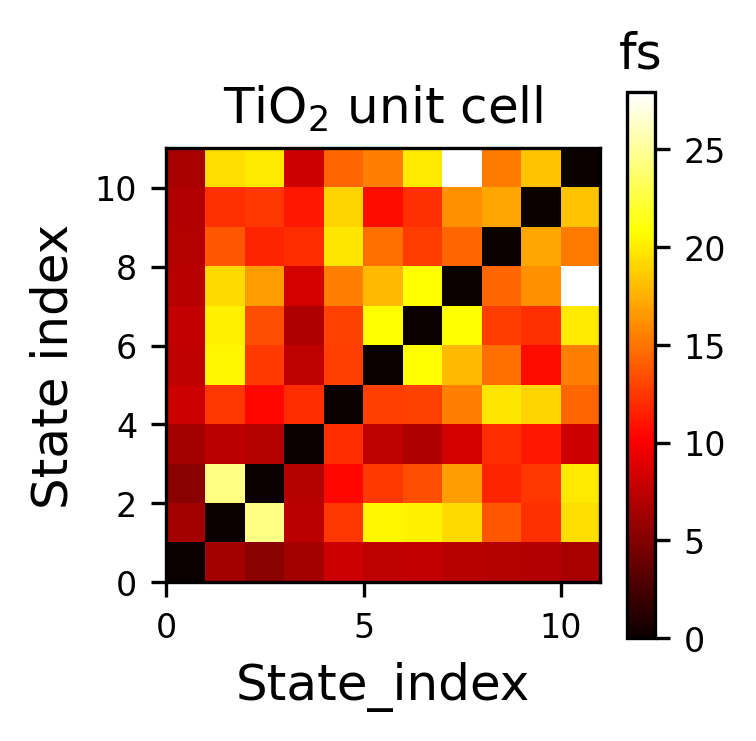

In [4]:
%matplotlib inline
#notebook
figure = plt.figure(num=None, figsize=(2.41, 2.41), dpi=300, edgecolor='black', frameon=True)        

avg_deco = np.loadtxt('average_decoherence.txt')
plt.imshow(np.flipud(avg_deco), extent=(0,avg_deco.shape[0],0,avg_deco.shape[1]), cmap='hot')
plt.colorbar().ax.set_title('fs')
plt.title('TiO$_2$ unit cell')
plt.xlabel('State_index')
plt.ylabel('State index')

## 6. Fitting data <a name="fit_data"></a>
[Back to TOC](#toc)


After the dynamic is done, we load all the NA-MD results, stored in `SH_pop.txt` files, using `np.loadtxt` and start fitting them to a stretched-compressed exponential function of the form:

$$P(t; E_0)=\exp(-(\frac{t}{\tau})^\beta)$$


Then, the average time scale is computed for the fits that has an $R^2$ value more than $0.01$. The error bars are computed using the following formula:

$$\epsilon=Z\frac{s}{\sqrt{N}}$$

where $s$ is the stadard deviaton and $N$ is the number of samples (the ones that have $R^2$ value of more than $0.01$). The $Z$ value is the confidence interval coefficient which for confidence interval of $95\%$, a value of $1.96$ is chosen.

In the above, we have only considered, FSSH and IDA ad for simplicity, we will consider the decay dynamics of the hot state which is the 10th state. Also, please note that this is just an example and we want to show how the workflow is. So, we consider even lower $R^2$ value. For better and more accurate results, we need not only longer trajectory but also larger number of surface hopping trajectory.

------------FSSH----------
Folder = ./ADI/_start_s10_FSSH_batch0
tau: 6603.650700332407  beta: 1.0  R2: -0.7183998695881662
Folder = ./ADI/_start_s10_FSSH_batch1
tau: 8066.259946213761  beta: 1.0  R2: 0.854576782340992
Folder = ./ADI/_start_s10_FSSH_batch2
tau: 25885.35083211476  beta: 1.0  R2: 0.26531426841693073
Folder = ./ADI/_start_s10_FSSH_batch3
tau: 8175.034460254808  beta: 1.0  R2: 0.8629410182240902
The timescales: 14042.215079527776+-9476.615486053839 average over 3 samples
------------IDA----------
Folder = ./ADI/_start_s10_IDA_batch0
tau: 69329.99146821623  beta: 1.0  R2: -inf
Folder = ./ADI/_start_s10_IDA_batch1
tau: 25885.35083211476  beta: 1.0  R2: 0.26531426841693073
Folder = ./ADI/_start_s10_IDA_batch2
tau: 8175.034460254808  beta: 1.0  R2: 0.8629410182240902
Folder = ./ADI/_start_s10_IDA_batch3
tau: 6603.650700332407  beta: 1.0  R2: -0.7183998695881662
The timescales: 17030.192646184783+-12272.623107431278 average over 2 samples


/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars


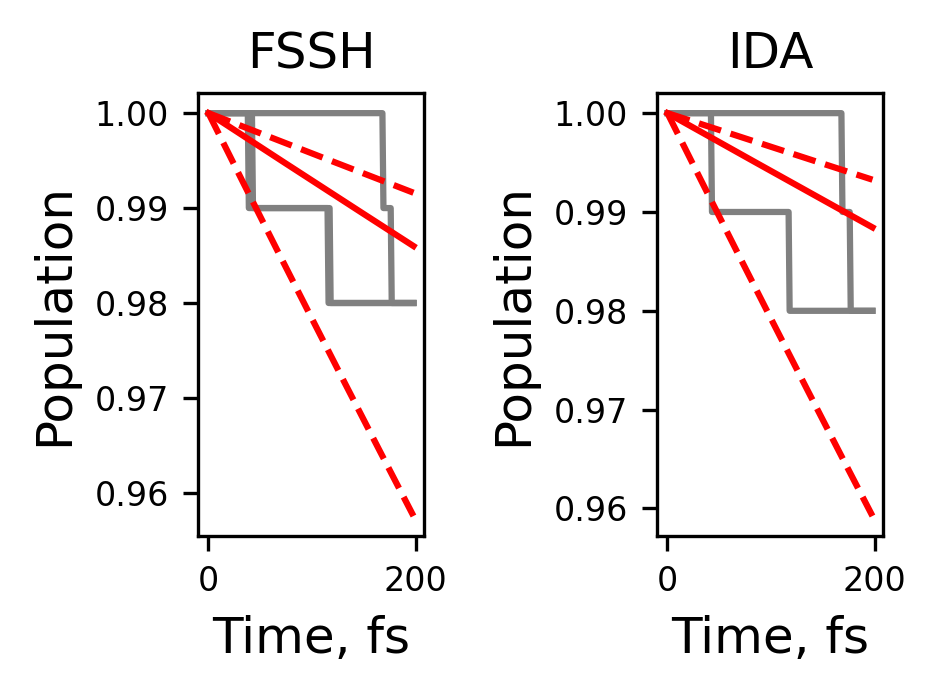

In [5]:
%matplotlib inline
#notebook
figure = plt.figure(num=None, figsize=(3.21, 2.41), dpi=300, edgecolor='black', frameon=True)        

def stretched_compressed(t, tau, beta):
    #return np.exp( -np.power(( t/tau ),beta) )
    return np.exp(-t/tau)

#for c, scheme in enumerate(['adiabatic', 'FSSH', 'IDA']):
for c, scheme in enumerate (['FSSH', 'IDA']):
    
    print(F'------------{scheme}----------')
    plt.subplot(1,2,c+1)
    folders = glob.glob(F'./ADI/_start_s10_{scheme}_batch*', recursive = True)
    taus = []
    betas = []
    
    for folder in folders:
        
        print("Folder =", folder)
        sh_pop = np.loadtxt(folder+'/SH_pop.txt')
        sh_pop_hot_state = sh_pop[:,10]
        md_time = np.arange(0, sh_pop_hot_state.shape[0], 1.0)
        popt, pcov = curve_fit( stretched_compressed, md_time, sh_pop_hot_state, 
                                   bounds=([0.0, 0.0],[np.inf, np.inf]))
        tau, beta = popt
        # Computing the R-squared
        residuals  = sh_pop_hot_state - stretched_compressed(md_time, *popt)
        ss_res     = np.sum(residuals**2)
        ss_tot     = np.sum((sh_pop_hot_state - np.mean(sh_pop_hot_state))**2)
        r_squared  = 1.0 - (ss_res / ss_tot)
        print('tau:', tau, ' beta:', beta,' R2:', r_squared)
        
        if r_squared>0.01:
            taus.append(tau)
            betas.append(beta)
            plt.plot(md_time, sh_pop_hot_state, color='gray')
            
    ave_tau = np.average(np.array(taus))
    ave_beta = np.average(np.array(betas))
    # Compute the erro bars
    # The confidence interval
    Z = 1.96
    N = len(taus)
    s = np.std(np.array(taus))
    error_bar = Z*s/np.sqrt(N)
    print(F'The timescales: {ave_tau}+-{error_bar} average over {len(taus)} samples')
    
    # Plot average fit
    
    plt.plot(md_time, stretched_compressed(md_time, ave_tau-error_bar, ave_beta), ls='--', color='red')
    plt.plot(md_time, stretched_compressed(md_time, ave_tau,           ave_beta), ls='-',  color='red')
    plt.plot(md_time, stretched_compressed(md_time, ave_tau+error_bar, ave_beta), ls='--', color='red')
    
    plt.title(scheme)
    plt.xlabel('Time, fs')
    plt.ylabel('Population')
    plt.tight_layout()

        
        